## MNIST

`MNIST` の代わりに`FashionMNIST` を用いることもできる．MNISTは易しい課題であるため，MNISTを訓練できるからと言って複雑な課題でも機能する保証はない．とは言え，基本的なデータセットであるため，

In [32]:
using Base: @kwdef
using LinearAlgebra, Random, PyPlot, ProgressMeter, Statistics
using MLDatasets
include("../codes/neural_networks.jl")
rc("axes.spines", top=false, right=false)

In [86]:
trainset = MNIST(:train)
testset = MNIST(:test)

X_train, y_train = trainset[:]; # return all observations
println("X_train: $(size(X_train)), y_train: $(size( y_train))")

X_train: (28, 28, 60000), y_train: (60000,)


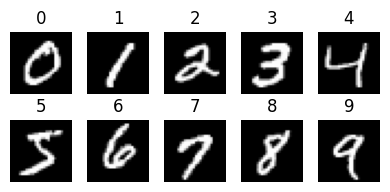

In [80]:
first_sample_indices = [findfirst(y_train .== i) for i in 0:9]

fig, axes = subplots(2, 5, figsize=(4, 2))
for i in 1:10
    idx = first_sample_indices[i]
    col, row = (i-1)%5+1, div(i-1, 5)+1
    axes[row, col].set_title("$(y_train[idx])")
    axes[row, col].imshow(X_train[:, :, idx]', cmap="gray")
    axes[row, col].axis("off")
end
tight_layout()

初回実行時はデータセットのダウンロードを行うか`[y/n]` (yes/no) の入力を求められるので`y`と入力する．

In [ ]:
X_train = Matrix(reshape(X_train, (:, length(trainset)))') 
y_train .+= 1; # 0-9 to 1-10

In [5]:
# training θeter
n_traindata = 60000 #or length(trainset)
n_batch = 200 # batch size
n_iter_per_epoch = round(Int, n_traindata/n_batch)
n_epoch = 10; # number of epoch

In [6]:
n_classes = 10
nn = MLP([28^2, 128, 64, n_classes], [ReLU(), ReLU(), Softmax()]; init_type="He")
loss_fun1 = cross_entropy_loss!

lr = 1e-3  # learning rate
weight_decay = 1e-4 # weight decay (L2 norm) strength
optimizer = Adam(lr=lr)
shuffle_data = true

true

In [20]:
error_arr = zeros(n_epoch); # memory array of each epoch error

#@showprogress "Training..." 
for e in 1:n_epoch
    if e == round(Int, n_epoch/2)
        optimizer.lr *= 0.1
    end
    if shuffle_data
        shuffle_indices = shuffle(1:n_traindata)
        X_train = X_train[shuffle_indices, :];
        y_train = y_train[shuffle_indices]
    end
    for iter in 1:n_iter_per_epoch
        idx = (iter-1)*n_batch+1:iter*n_batch
        x, y = X_train[idx, :], y_train[idx]
        loss = train_step!(nn, x, y, loss_fun1, optimizer=optimizer, weight_decay=weight_decay)
        error_arr[e] += loss
    end 
    error_arr[e] /= n_traindata
    println("[$(lpad(e, ndigits(n_epoch), '0'))/$(n_epoch)] train loss: $(error_arr[e])")
end

[001/100] train loss: 0.0017442144951195738
[002/100] train loss: 0.0007518473289101778
[003/100] train loss: 0.0006131336300990896
[004/100] train loss: 0.000563950756416515
[005/100] train loss: 0.0005310865807820935
[006/100] train loss: 0.0005365005703820264
[007/100] train loss: 0.0005105431269052053
[008/100] train loss: 0.000489347132660195
[009/100] train loss: 0.0004981383050794982
[010/100] train loss: 0.0004631494064889465
[011/100] train loss: 0.00043653411667142743
[012/100] train loss: 0.00045796085301944077
[013/100] train loss: 0.0004058814776783354
[014/100] train loss: 0.00038065373553870986
[015/100] train loss: 0.0003537122445233366
[016/100] train loss: 0.0003311199469918154
[017/100] train loss: 0.00031608091622687957
[018/100] train loss: 0.00031804212857177973
[019/100] train loss: 0.00028271323400105614
[020/100] train loss: 0.00026951154090734084
[021/100] train loss: 0.0002085164026955853
[022/100] train loss: 0.00019998893993304143
[023/100] train loss: 0.00

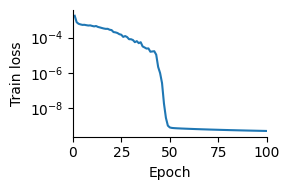

In [21]:
figure(figsize=(3,2))
semilogy(1:n_epoch, error_arr)
ylabel("Train loss"); xlabel("Epoch"); xlim(0, n_epoch)
tight_layout()

In [9]:
X_test, y_test = testset[:];

In [10]:
n_test = length(testset)

10000

In [22]:
size(nn.W[1].v)

(784, 128)

Dying Relu現象

In [30]:
size(nn.W[1].v')

(128, 784)

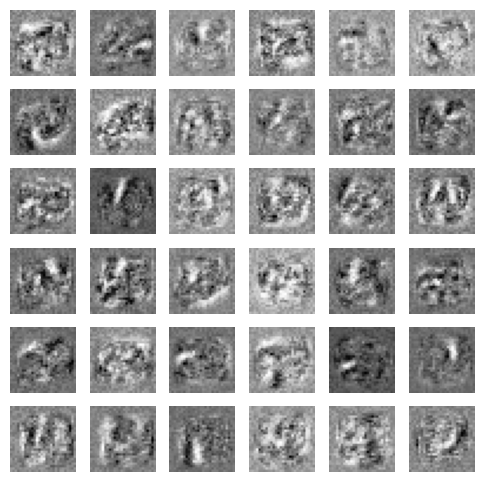

In [31]:
weight = reshape(nn.W[1].v'[1:36, :], (36, 28, 28));

fig, axes = subplots(6, 6, figsize=(6,6))
axf = axes[:]
for i in 1:36
    axf[i].imshow(weight[i, :, :], cmap="Greys")
    axf[i].axis("off")
end

In [23]:
#x_test = Matrix(reshape(((X_test .- X_mean) ./ X_std), (28^2, :))');
x_test = Matrix(reshape(X_test, (28^2, :))');

In [24]:
y_pred = nn(x_test);

In [25]:
t_pred = getindex.(argmax(y_pred, dims=2), 2) .- 1;

In [26]:
accuracy = sum(t_pred .== y_test) / n_test * 100

98.14

In [27]:
confusion_matrix = zeros(n_classes, n_classes)
for i in 1:n_test
    confusion_matrix[y_test[i]+1, t_pred[i]+1] += 1
end

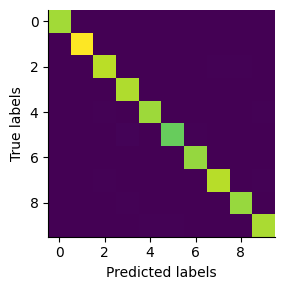

In [28]:
figure(figsize=(3,3))
imshow(confusion_matrix)
xlabel("Predicted labels")
ylabel("True labels")
tight_layout()